## Time Series Stock Price Prediction

### series = trend + seasons + cycles + error

In [1]:
from pathlib import Path
from warnings import simplefilter

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from xgboost import XGBRegressor

simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

#### Loading historical stock price data

In [3]:
#Load Ticker Price dataset
ticker = pd.read_excel("ticker_report_2022-07-02.xlsx", parse_dates=["DATE"])
ticker = ticker.set_index("DATE").to_period('D')
ticker = ticker.loc['6/1/2020':]

ticker.head()

,CLOSE
DATE,
2020-06-01,3345.9
2020-06-02,3489.3
2020-06-06,3654.1
2020-06-07,3836.6
2020-06-08,3988.2


In [4]:
df = ticker.copy()

df['Time'] = np.arange(len(ticker.index))

### Forecasting Price

In [5]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'CLOSE']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

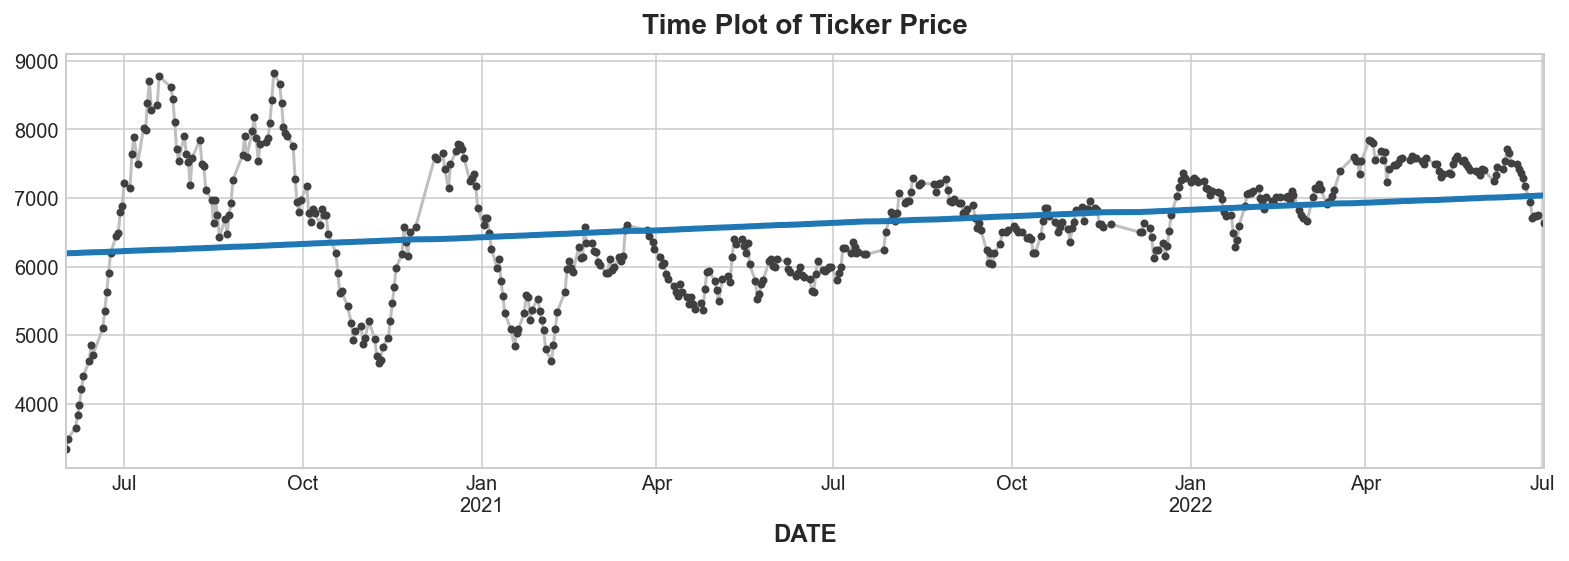

In [6]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Ticker Price');

In [7]:
df['Lag_1'] = df['CLOSE'].shift(1)
df.head()

,CLOSE,Time,Lag_1
DATE,,,
2020-06-01,3345.9,0,NaN
2020-06-02,3489.3,1,3345.9
2020-06-06,3654.1,2,3489.3
2020-06-07,3836.6,3,3654.1
2020-06-08,3988.2,4,3836.6


In [8]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'CLOSE']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

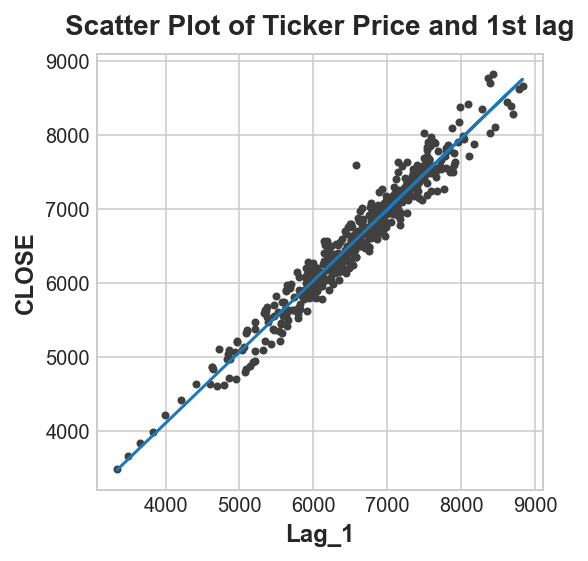

In [9]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('CLOSE')
ax.set_xlabel('Lag_1')
ax.set_title('Scatter Plot of Ticker Price and 1st lag');

#### Price forecast using 1st lag

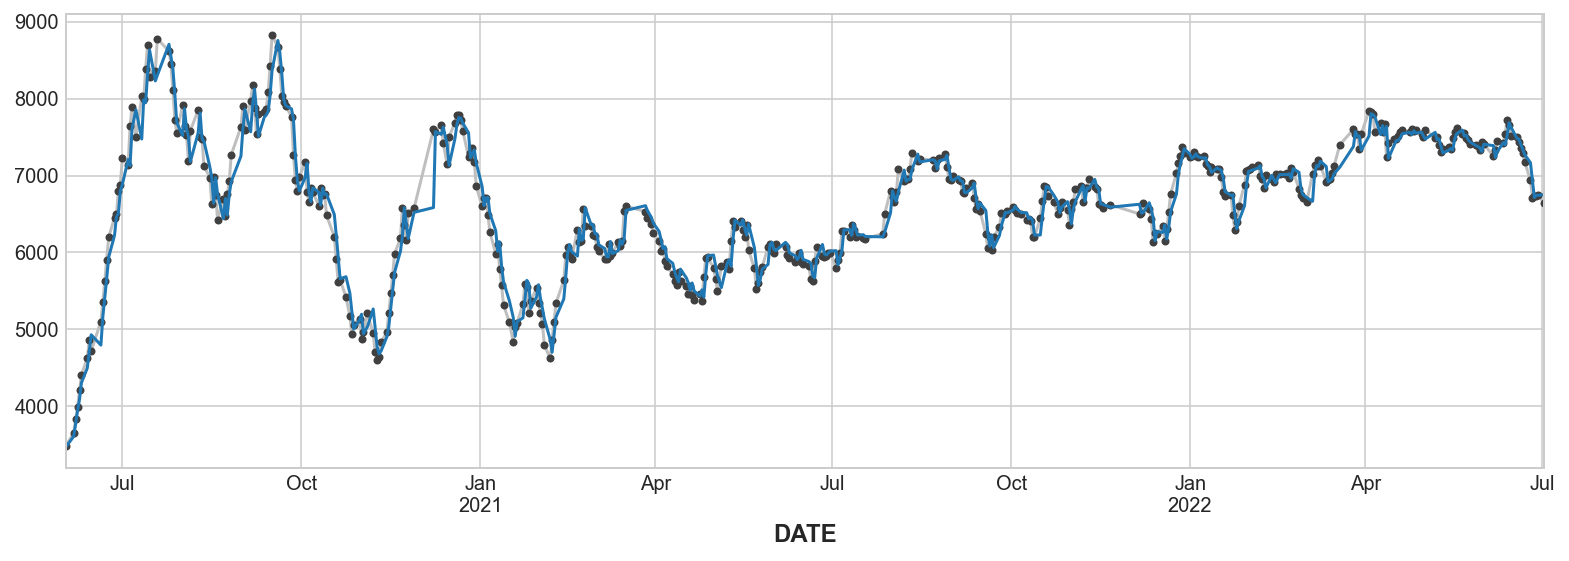

In [10]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

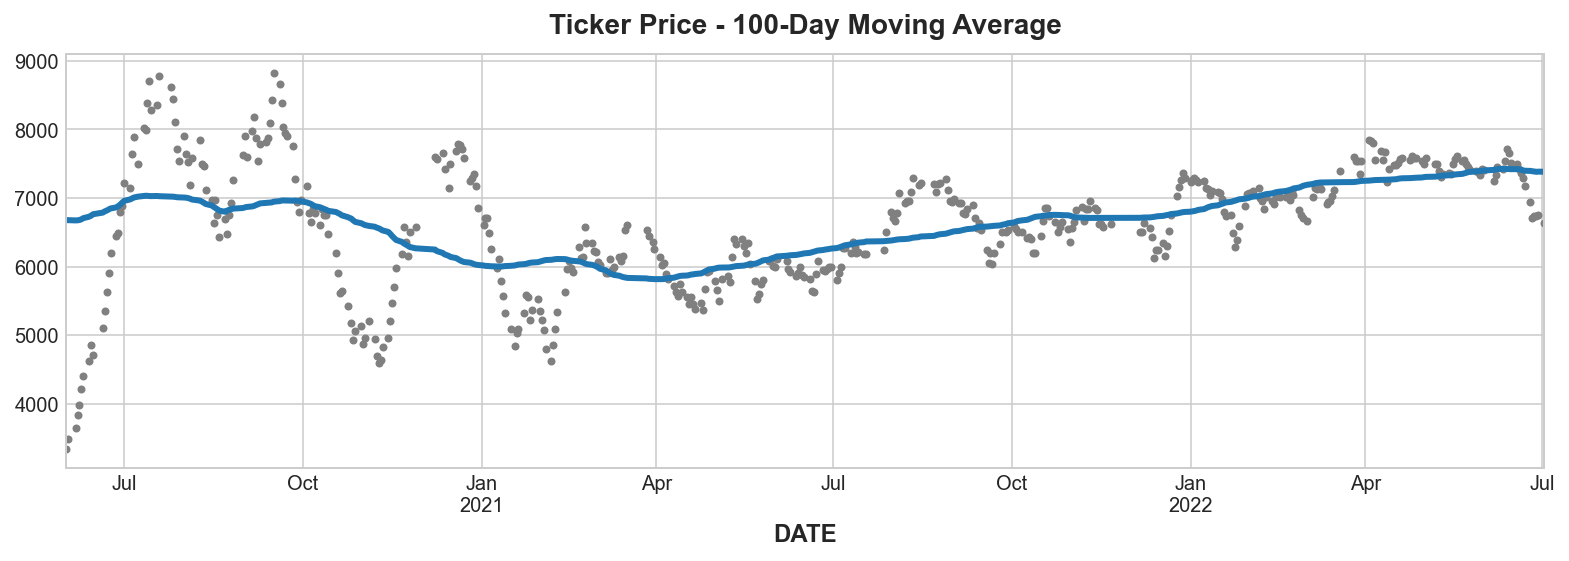

In [11]:
moving_average = ticker['CLOSE'].rolling(
    window=100,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=50,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = ticker['CLOSE'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Ticker Price - 100-Day Moving Average", legend=False,
);

In [12]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=ticker.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
DATE,,
2020-06-01,1.0,1.0
2020-06-02,1.0,2.0
2020-06-06,1.0,3.0
2020-06-07,1.0,4.0
2020-06-08,1.0,5.0


In [13]:
from sklearn.linear_model import LinearRegression

y = ticker["CLOSE"]  # the target

# The intercept is the same as the `const` feature from
# Deterministic Process. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

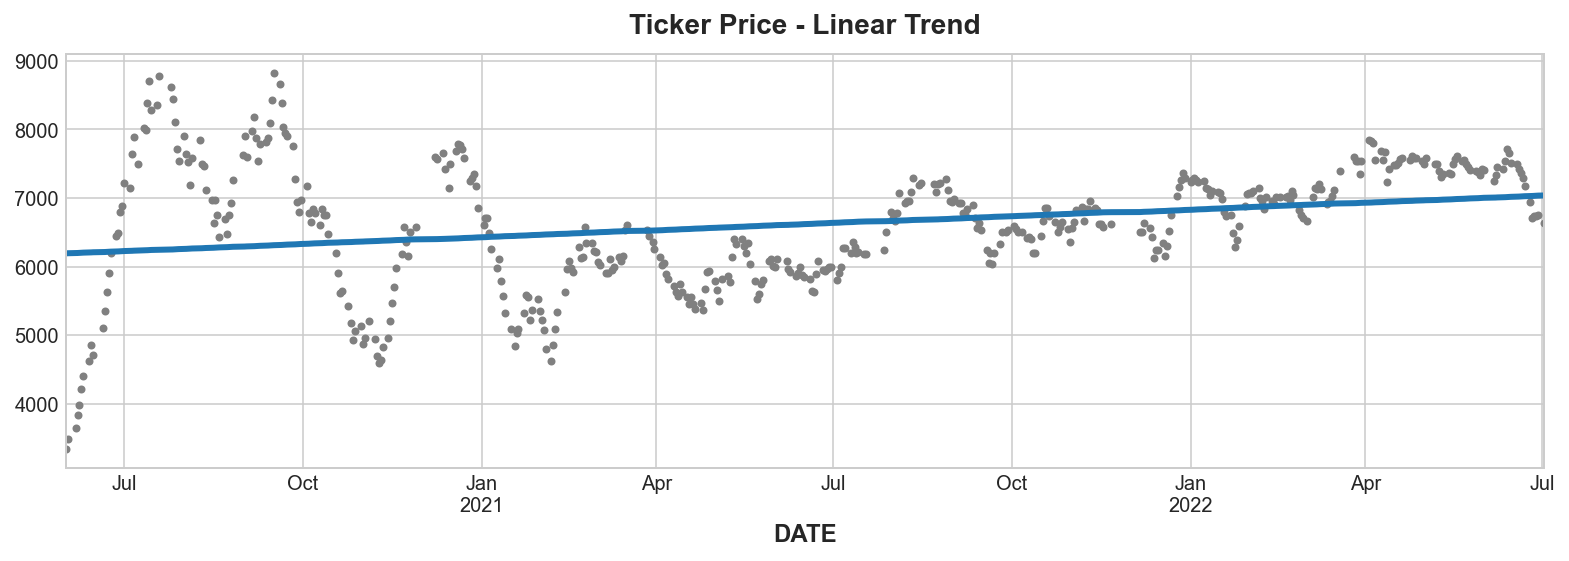

In [14]:
ax = ticker['CLOSE'].plot(style=".", color="0.5", title="Ticker Price - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

### Linear Trend Forecast

In [15]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-07-03    7039.678791
2022-07-04    7041.454741
2022-07-05    7043.230691
2022-07-06    7045.006641
2022-07-07    7046.782591
Freq: D, dtype: float64

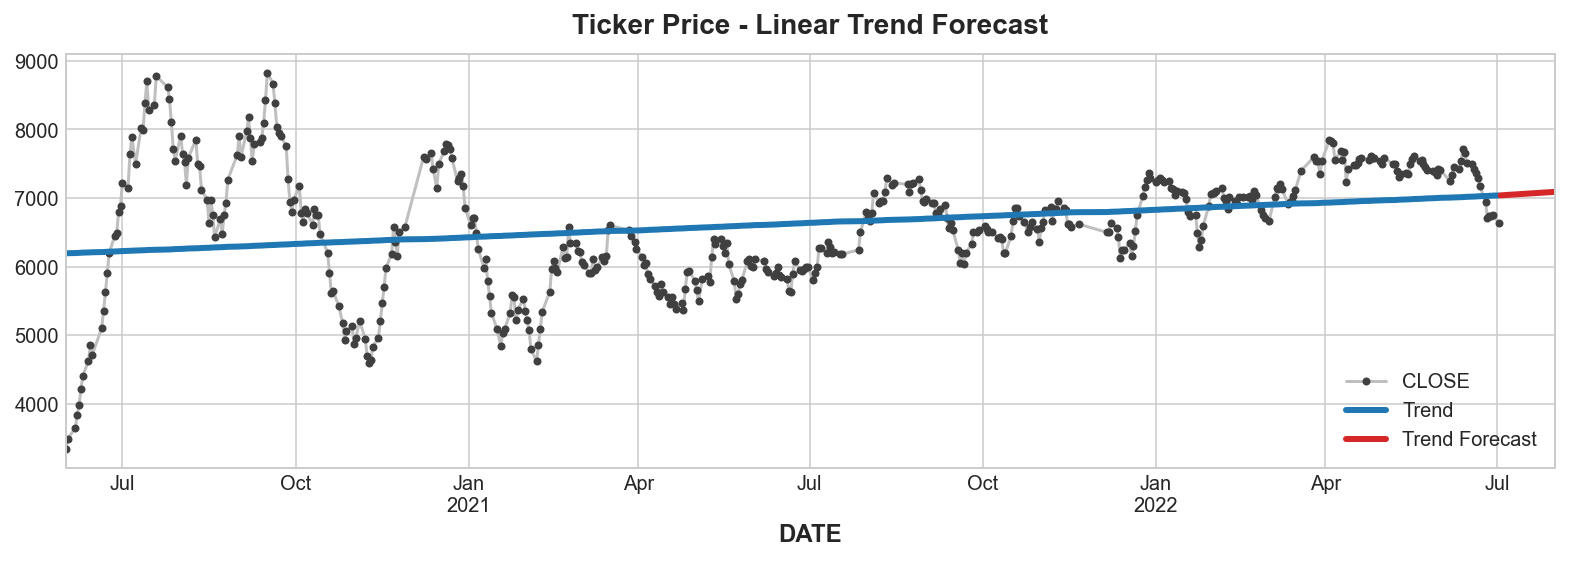

In [16]:
ax = ticker['CLOSE']["2005-05":].plot(title="Ticker Price - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

### Seasonal Plots and Seasonal Indicators for Price Forecasting

In [17]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

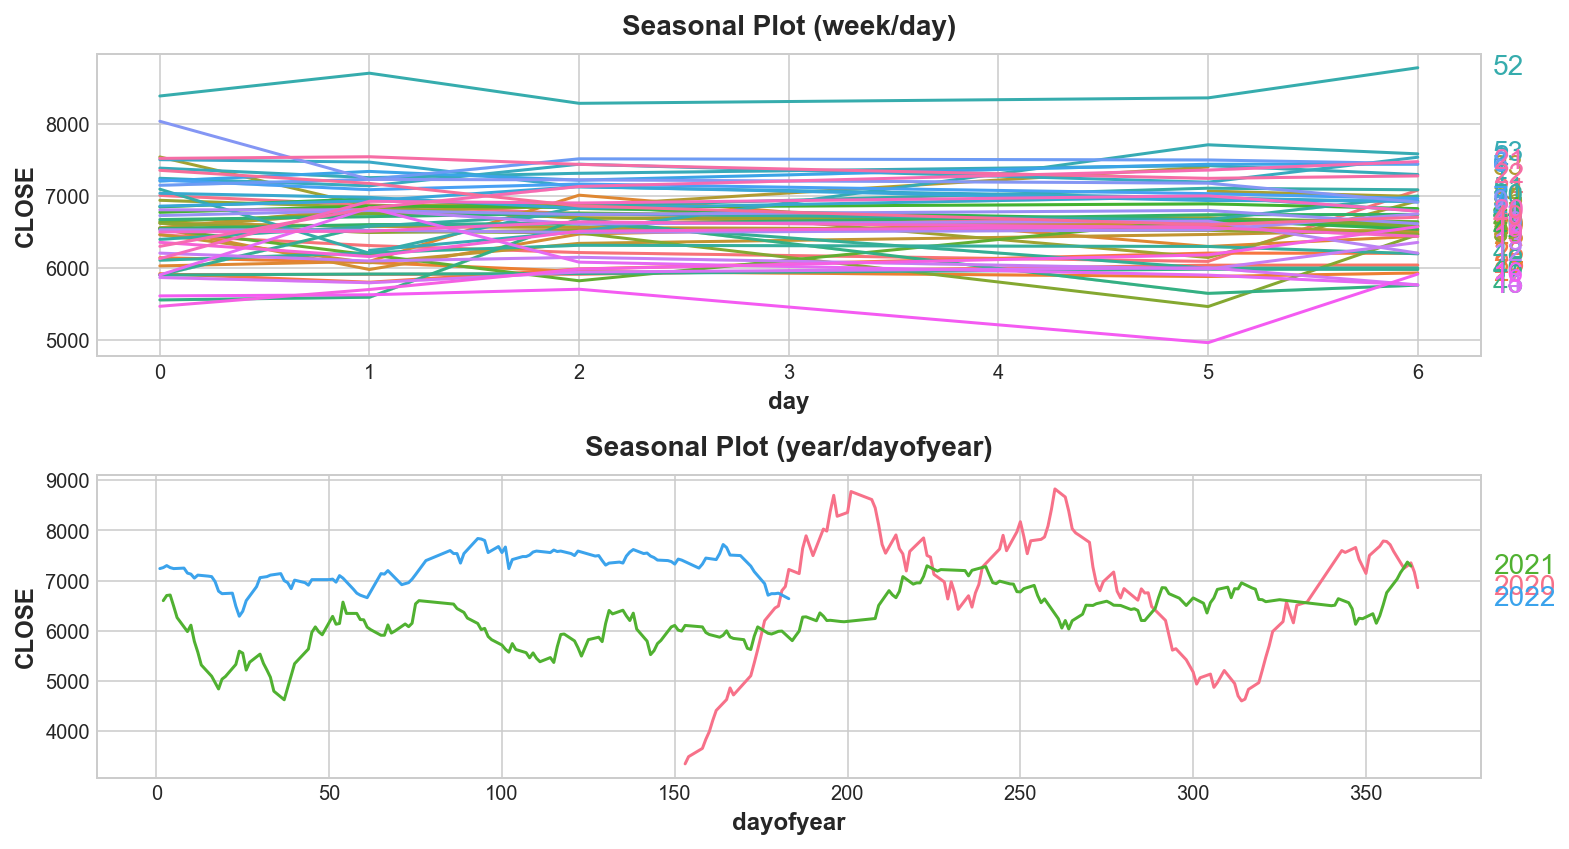

In [18]:
X = ticker.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="CLOSE", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="CLOSE", period="year", freq="dayofyear", ax=ax1);

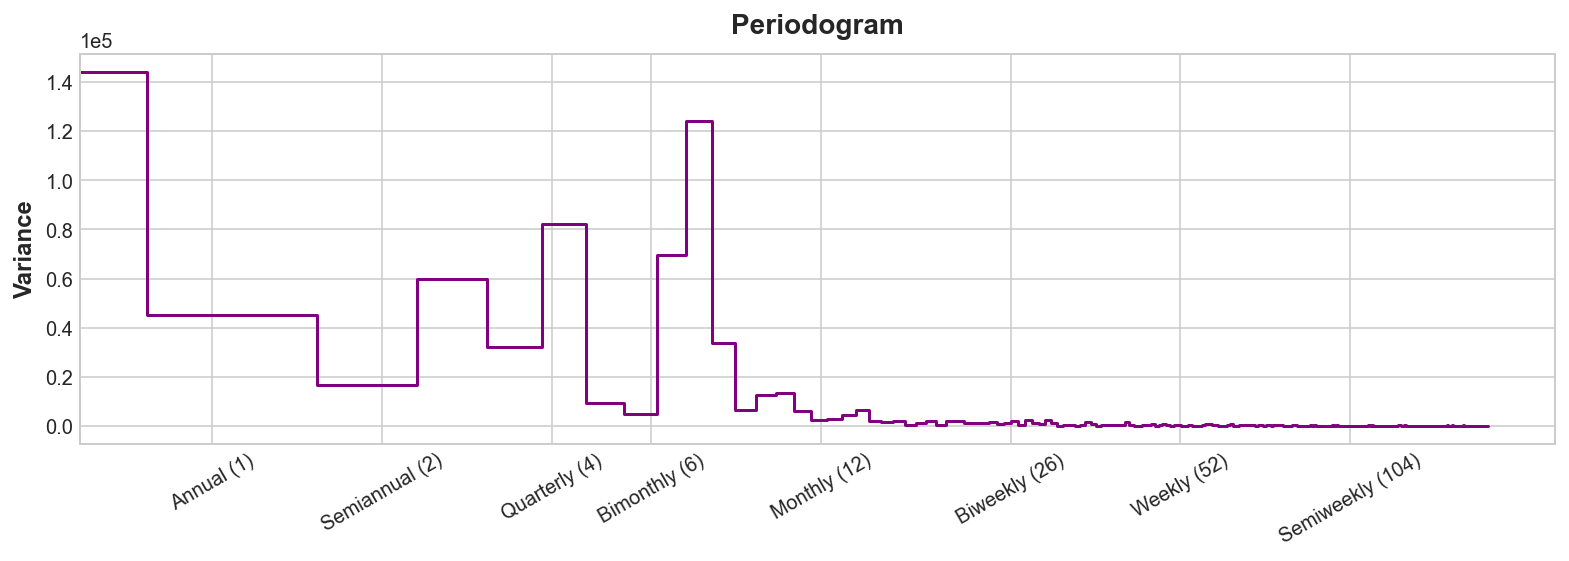

In [19]:
plot_periodogram(ticker.CLOSE);

### Seasonal Forecasting

In [20]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=ticker.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

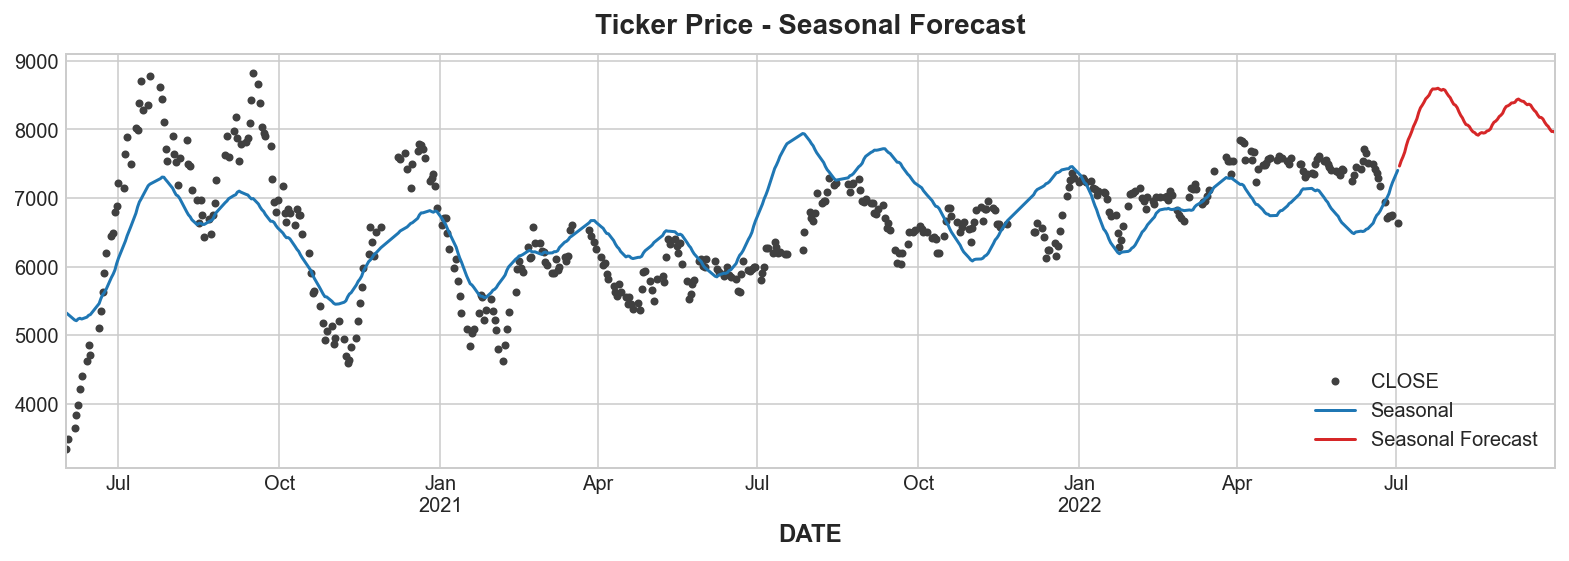

In [21]:
y = ticker["CLOSE"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Ticker Price - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

### Predicting ticker price from the past with a lag embedding

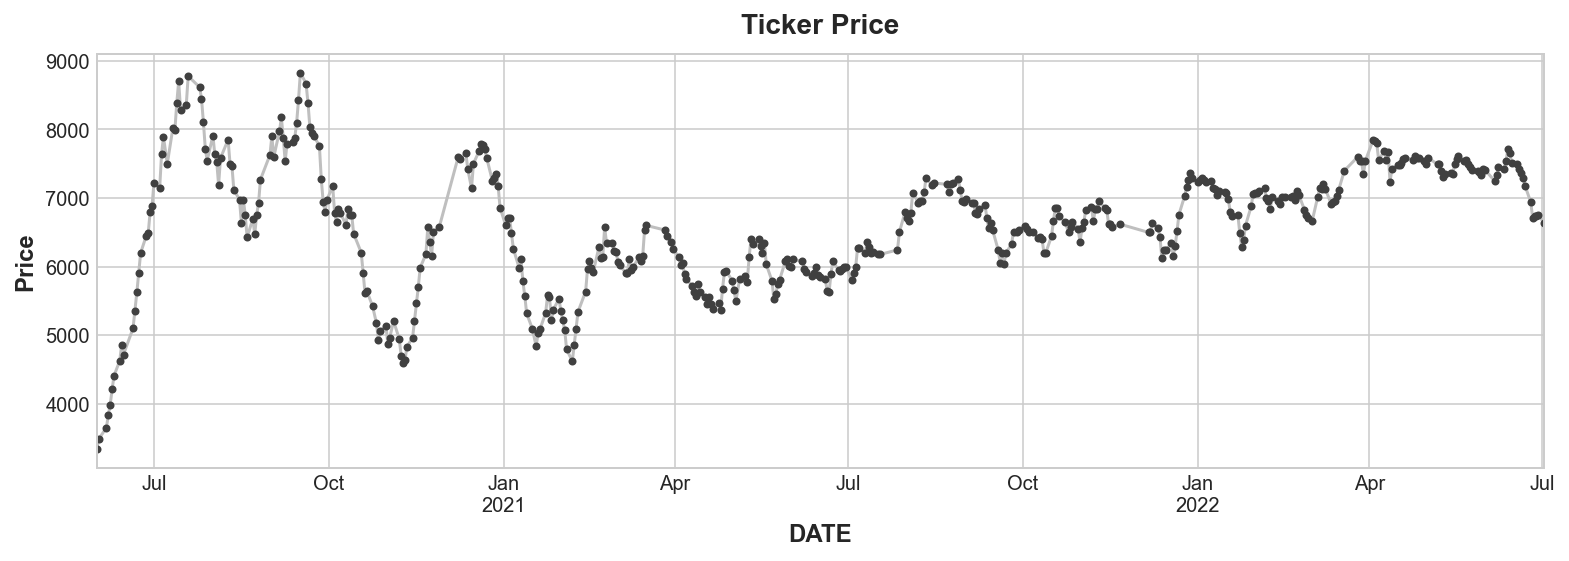

In [22]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

ax = ticker.CLOSE.plot(title='Ticker Price', **plot_params)
_ = ax.set(ylabel="Price")

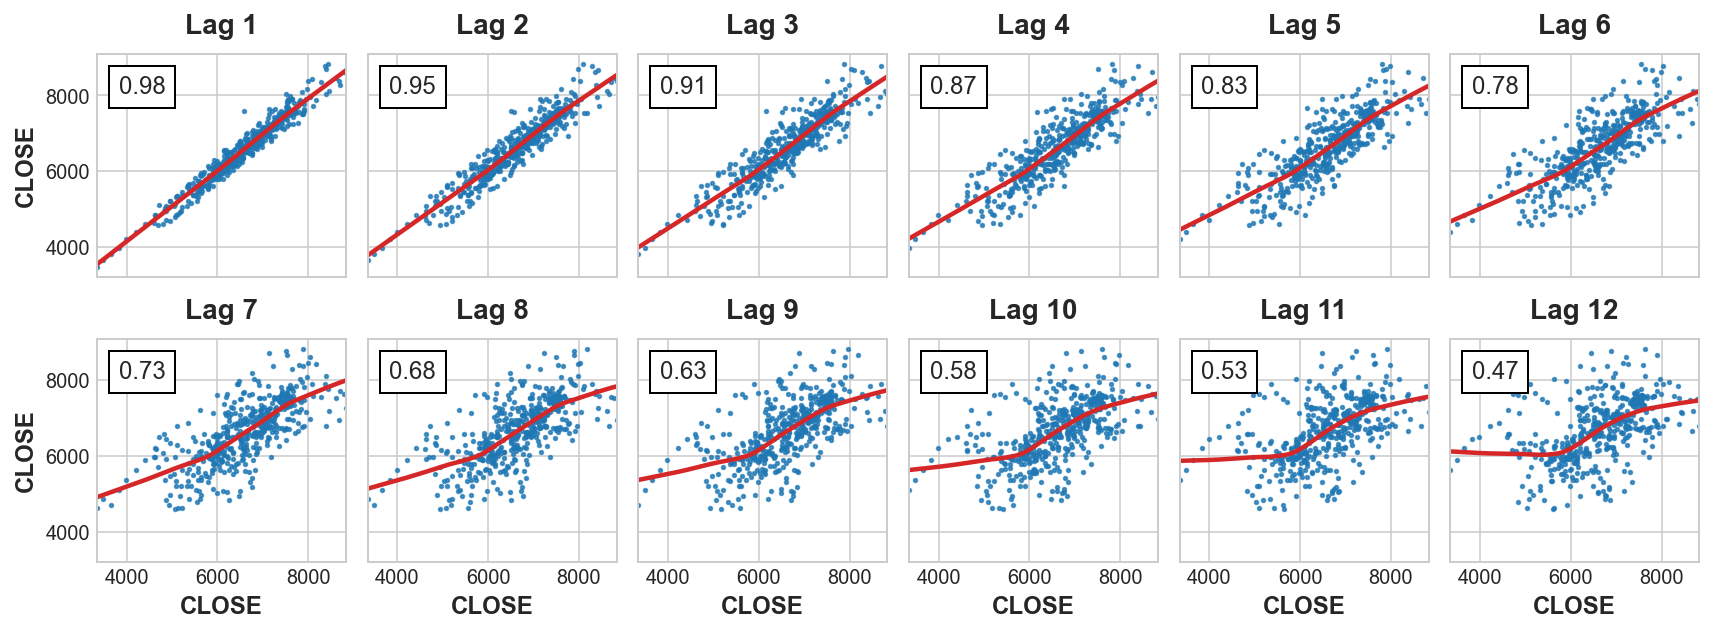

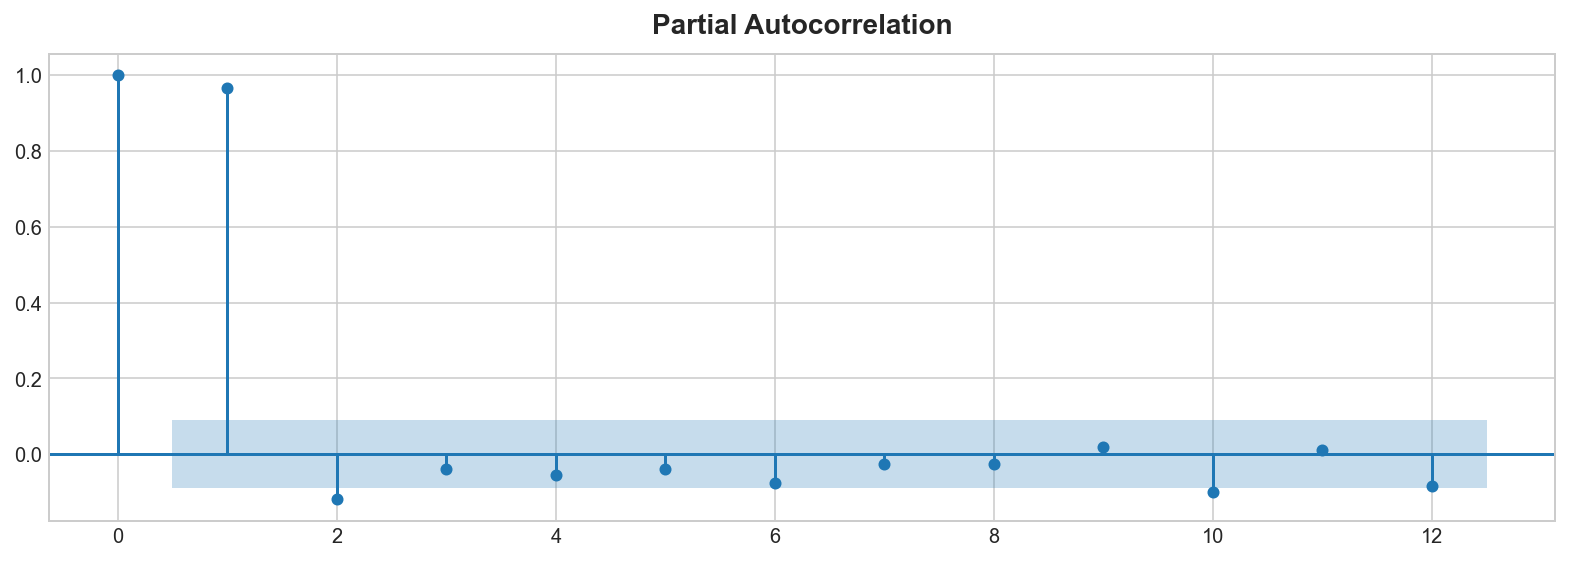

In [23]:
_ = plot_lags(ticker.CLOSE, lags=12, nrows=2)
_ = plot_pacf(ticker.CLOSE, lags=12)

In [24]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(ticker.CLOSE, lags=4)
X = X.fillna(0.0)

In [25]:
# Create target series and data splits
y = ticker.CLOSE.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

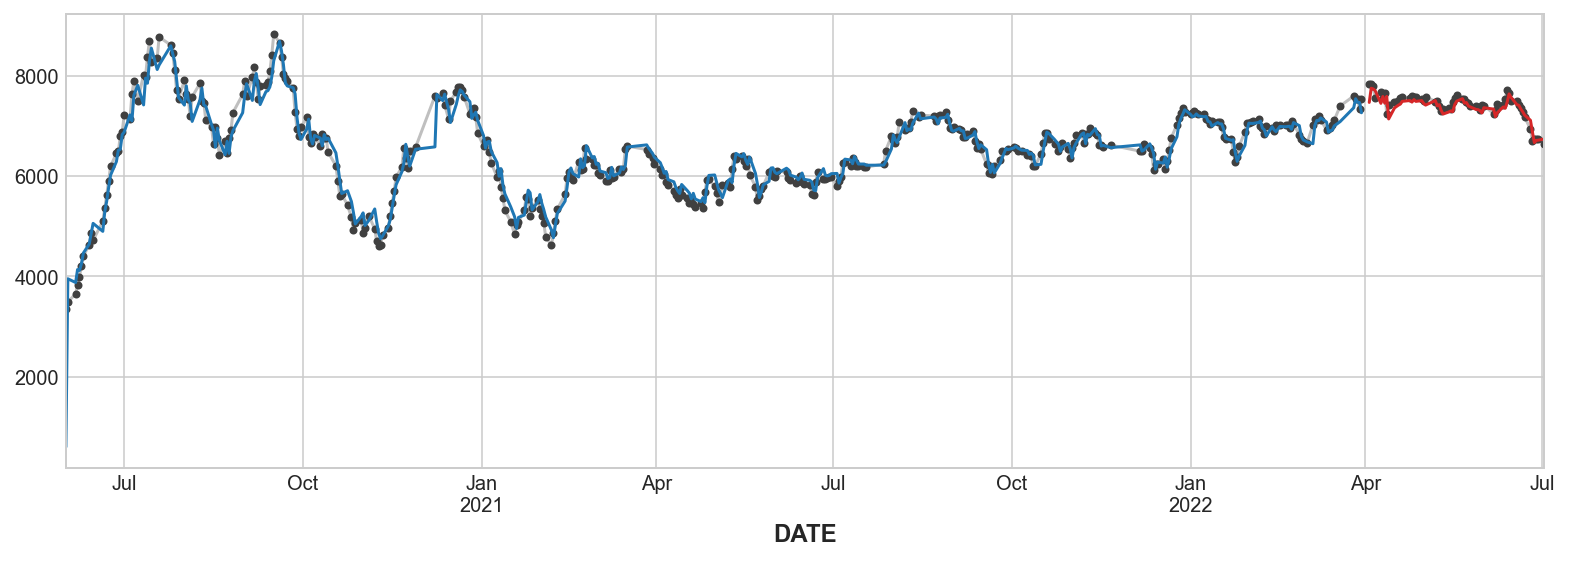

In [26]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

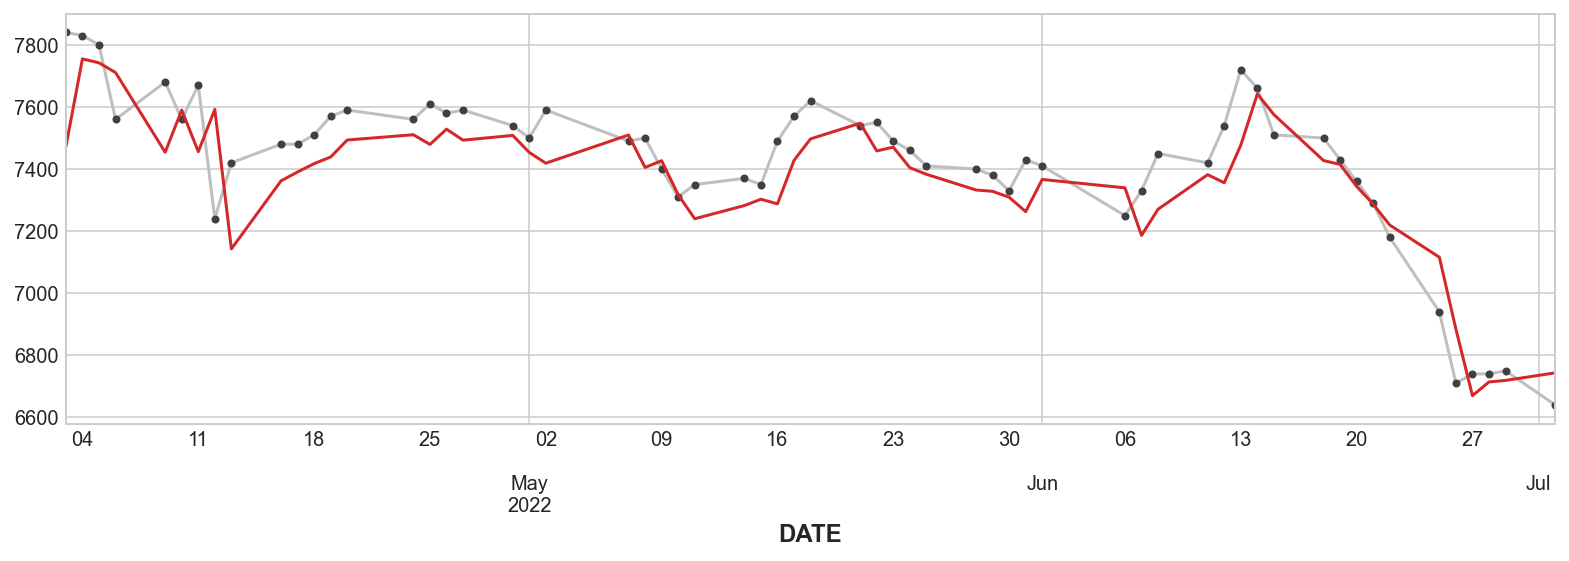

In [27]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')